In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
## getting the imports out of the way
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import matplotlib.pyplot as plt



In [3]:
experiments_and_query_lengths = {
    "403166": 16,
    "403165": 46,
    "403164": 114,
    "403155": 214,
}

In [4]:
# load all the parquet files
experiment_dfs = {}
for k,v in experiments_and_query_lengths.items():
    experiment_dfs[v] = pd.read_parquet(f"./parquets/{k}.parquet")

In [42]:
lel = experiment_dfs[16].groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
((lel.last()-lel.first())[idx[:,:,"deserialize"]] / np.timedelta64(1, "ms")).describe()

count    162.000000
mean       5.461827
std        0.470808
min        4.394000
25%        5.614250
50%        5.645000
75%        5.676000
max        5.768000
Name: timestamp, dtype: float64

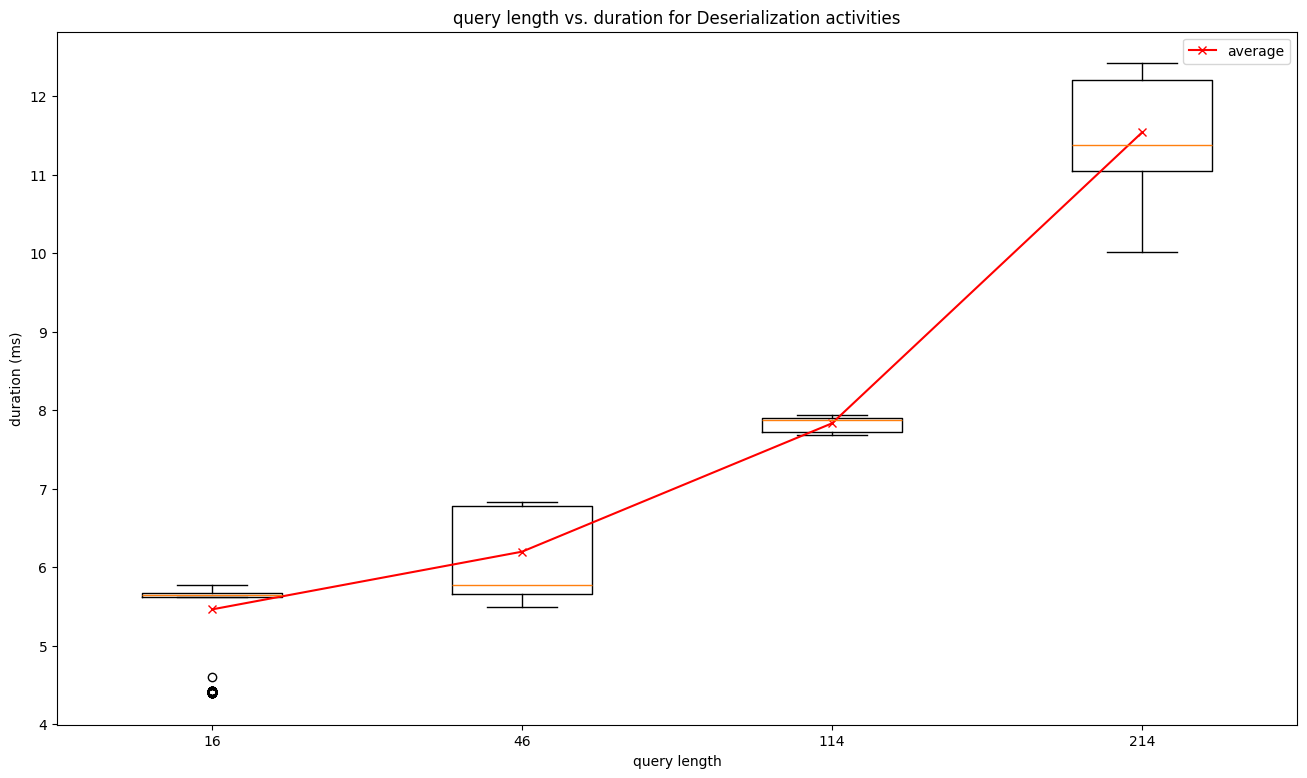

In [41]:
# lets do a box plot of duration on serialization
plt.figure(figsize=(16,9))
data = []
averages = []
labels = []
for k,v in experiment_dfs.items():
    labels.append(k)
    group = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (group.last() - group.first())[idx[:,:,"deserialize"]] / np.timedelta64(1, "ms")
    averages.append(differences.mean())
    data.append(differences)
plt.boxplot(data, tick_labels=labels)
plt.plot(np.arange(len(averages)) + 1,averages, "r-x", label="average")

plt.ylabel("duration (ms)")
plt.xlabel("query length")
plt.title("query length vs. duration for Deserialization activities")
plt.legend()
plt.show()

In [6]:
# now figure out the power consumed per activity
# we do this by figuring out what the total power consumed is per node_id,loop_num,activity.
# to find that we need the time difference between each timestamp and the previous one in seconds and then multiply that with the wattage to get power consumed in WattSeconds or joule for that time slice.
# we then sum over the whole activity to get the total count of joules
for k,v in experiment_dfs.items():
    v["timestamp_diff"]  = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"].diff()
    v["joule"] = v["timestamp_diff"].dt.total_seconds() * v["power"]


In [7]:
v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"deserialize"]]

node_id           loop_num
70B3D57ED005EA60  1.0         0.003384
                  2.0         0.003725
                  3.0         0.003747
                  4.0         0.003745
                  5.0         0.003739
                                ...   
70B3D57ED005EA68  19.0        0.003157
                  20.0        0.003162
                  21.0        0.003218
                  22.0        0.003179
                  23.0        0.003175
Name: joule, Length: 157, dtype: float64

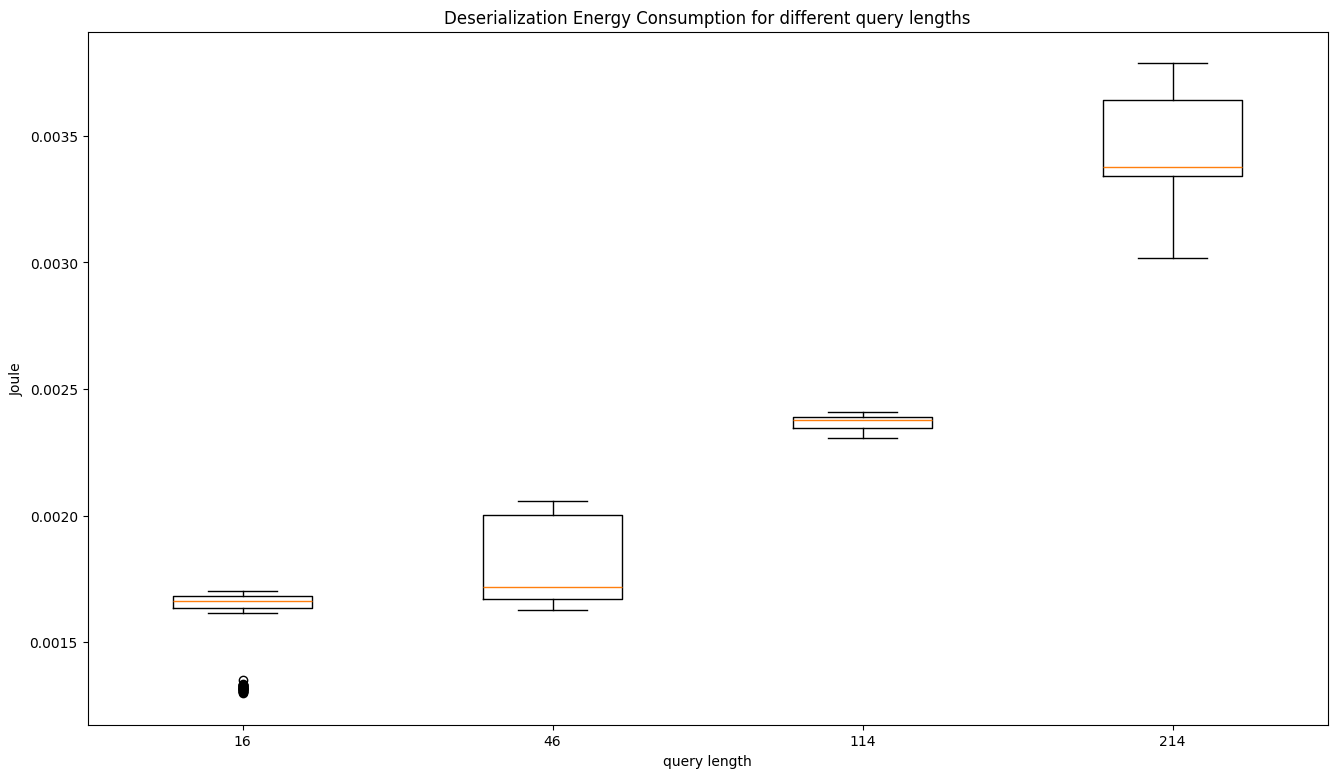

In [10]:
## lets see if we can plot the deserialization energy consumptions for the different queries
plt.figure(figsize=(16,9))
labels = []
data = []

for k,v in experiment_dfs.items():
    data.append(v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"deserialize"]])
    labels.append(k)

plt.boxplot(data, tick_labels=labels)
plt.ylabel("Joule")
plt.xlabel("query length")
plt.title("Deserialization Energy Consumption for different query lengths")
plt.show()
